In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Load dataset
df = pd.read_csv("loan_data.csv")  # Replace with actual dataset path
print("Dataset loaded successfully!")

Dataset loaded successfully!


In [3]:
df.columns = df.columns.str.strip()  # Remove whitespace from column names
df = df.map(lambda x: x.strip() if isinstance(x, str) else x)

In [4]:
print(f"Missing values before cleaning:\n{df.isna().sum()}")

Missing values before cleaning:
person_age                        0
person_gender                     0
person_education                  0
person_income                     0
person_emp_exp                    0
person_home_ownership             0
loan_amnt                         0
loan_intent                       0
loan_int_rate                     0
loan_percent_income               0
cb_person_cred_hist_length        0
credit_score                      0
previous_loan_defaults_on_file    0
loan_status                       0
dtype: int64


In [5]:
# Ensure 'loan_status' is binary (0/1)
print("Unique values in 'loan_status' before mapping:", df['loan_status'].unique())

Unique values in 'loan_status' before mapping: [1 0]


In [6]:
# Convert target variable to binary (if needed)
if df['loan_status'].dtype == 'object':
    df['loan_status'] = df['loan_status'].map({'Y': 1, 'N': 0})

In [7]:
# Ensure 'loan_status' is valid
if df['loan_status'].isna().sum() > 0:
    raise ValueError("Target variable 'loan_status' contains NaN values after mapping!")

In [8]:
# Handle missing values
df.fillna(df.median(numeric_only=True), inplace=True)

In [9]:
if not df.mode().empty:
    df.fillna(df.mode().iloc[0], inplace=True)

In [10]:
# Split features and target
X = df.drop(columns=['loan_status'])
y = df['loan_status']

In [11]:
print(f"Dataset shape before splitting: X={X.shape}, y={y.shape}")

Dataset shape before splitting: X=(45000, 13), y=(45000,)


In [12]:
# Ensure y is not empty
if y.isna().sum() > 0:
    raise ValueError("Target variable 'loan_status' contains NaN after cleaning!")

if X.empty or y.empty:
    raise ValueError("Dataset is empty after preprocessing! Check data loading and cleaning steps.")

In [13]:
# Identify categorical and numerical features
categorical_features = X.select_dtypes(include=['object']).columns
numerical_features = X.select_dtypes(exclude=['object']).columns

In [14]:
# Preprocessing pipelines
num_pipeline = StandardScaler()
cat_pipeline = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer([
    ('num', num_pipeline, numerical_features),
    ('cat', cat_pipeline, categorical_features)
])

In [15]:
# Define model pipeline
model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

In [16]:
# Hyperparameter tuning
param_grid = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [None, 10, 20],
    'classifier__min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

In [17]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [18]:
# Train model
grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_

In [19]:
# Make predictions
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

In [20]:
# Evaluate model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
conf_matrix = confusion_matrix(y_test, y_pred)

In [21]:
# Print results
print(f'Best Parameters: {grid_search.best_params_}')
print(f'Accuracy: {accuracy * 100:.2f}%')
print(f'Precision: {precision * 100:.2f}%')
print(f'Recall: {recall * 100:.2f}%')
print(f'F1-score: {f1 * 100:.2f}%')
print(f'ROC AUC: {roc_auc * 100:.2f}%')

Best Parameters: {'classifier__max_depth': 20, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 300}
Accuracy: 92.99%
Precision: 90.01%
Recall: 77.00%
F1-score: 83.00%
ROC AUC: 97.51%


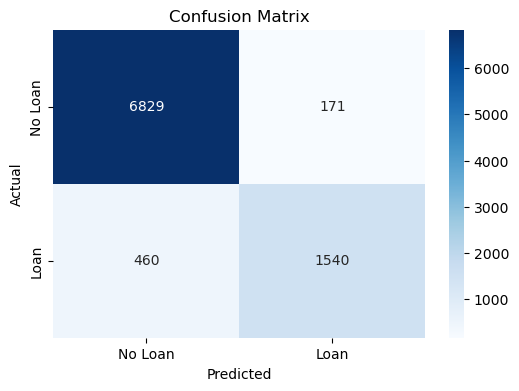

In [22]:
# Plot confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No Loan', 'Loan'], yticklabels=['No Loan', 'Loan'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()